In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
from pathlib import Path
from peak_performance import pipeline as pl, models, plots
from matplotlib import pyplot as plt

# Load and inspect raw intensity data

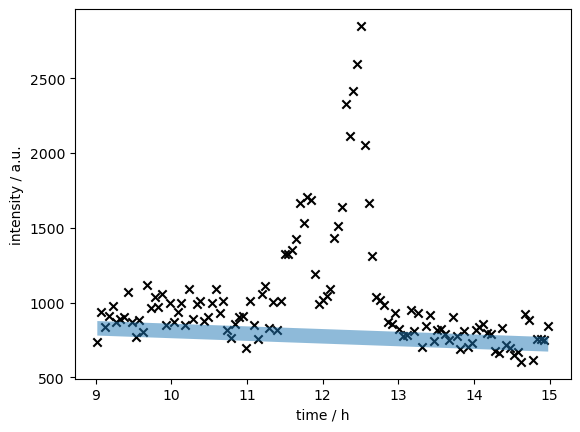

In [2]:
timeseries = np.load(Path(r"..\example\A2t2R1Part1_132_85.9_86.1.npy"))
time = timeseries[0]
ints = timeseries[1]

def guess_noise(intensity):
    n = len(intensity)
    ifrom = int(np.ceil(0.15 * n))
    ito = int(np.floor(0.85 * n))
    start_ints = intensity[:ifrom]
    end_ints = intensity[ito:]
    return np.std([*(start_ints - np.mean(start_ints)), *(end_ints - np.mean(end_ints))])

fig, ax = plt.subplots()
ax.scatter(timeseries[0], timeseries[1], marker="x", color="black")
slope, intercept, noise = models.initial_guesses(time, ints)
ax.fill_between(
    time,
    slope * time + intercept - noise / 2,
    slope * time + intercept + noise / 2,
    alpha=0.5
)
ax.set(
    xlabel="time / h",
    ylabel="intensity / a.u.",
)
plt.show()

# Define a peak model

c:\Users\osthege\AppData\Local\mambaforge\envs\pepe\Lib\site-packages\pymc\data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


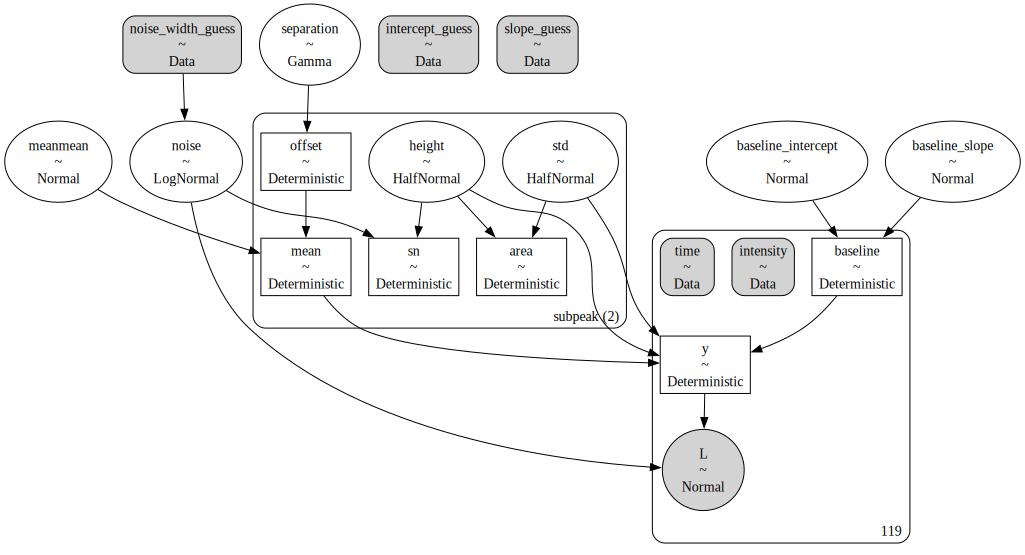

In [3]:
pmodel = models.define_model_double_normal(
    time=timeseries[0],
    intensity=timeseries[1]
)
pmodel.to_graphviz()

# Fix the `noise` settings using `pm.do`

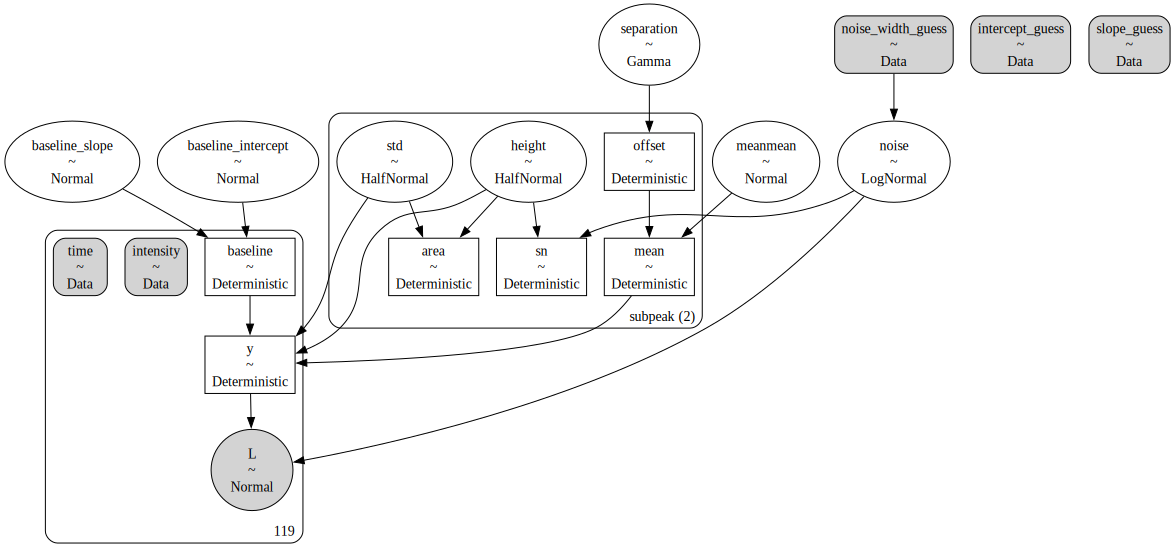

In [4]:
pm.do(pmodel, {"noise_width_guess": 100}).to_graphviz()

# Sample the models with fixed `noise`

In [5]:
sigma_idatas = {}
for s in [50, 100, 150, 200, 300, 400, 500]:
    spmodel = pm.do(pmodel, {"noise": s})
    sigma_idatas[s] = pl.sampling(spmodel, tune=6_000, draws=2000)
    sigma_idatas[s] = pl.posterior_predictive_sampling(spmodel, sigma_idatas[s])

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

Sampling: [L, baseline_intercept, baseline_slope, height, meanmean, separation, std]


Sampling: [L]


Output()

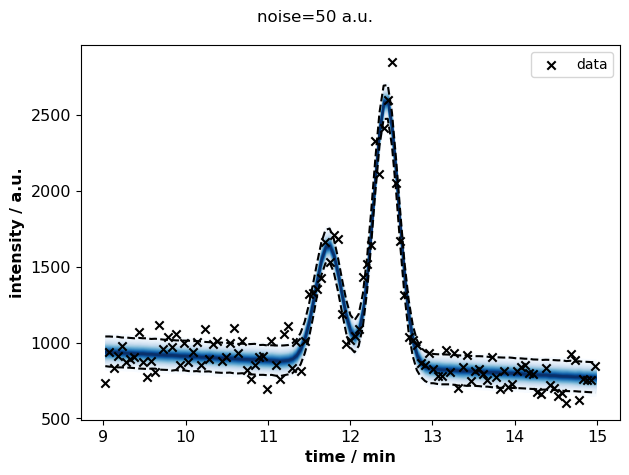

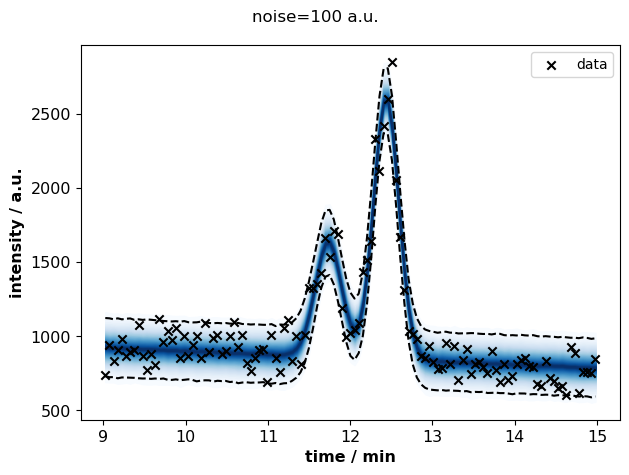

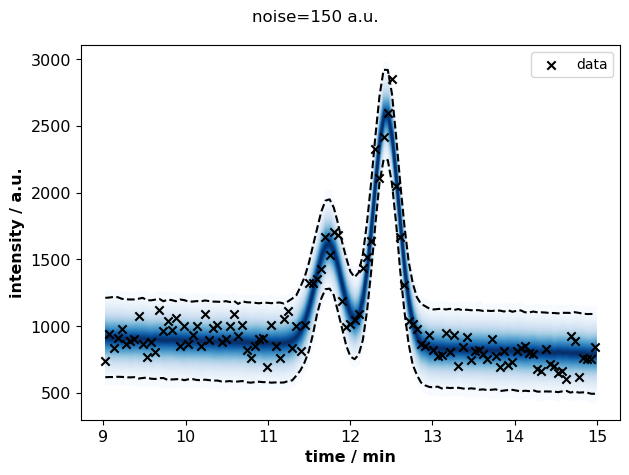

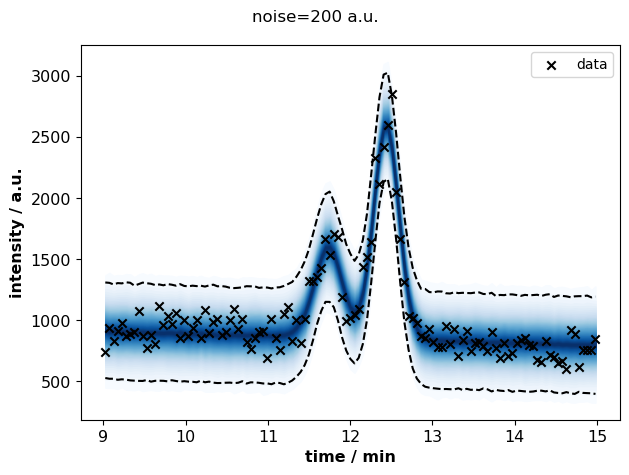

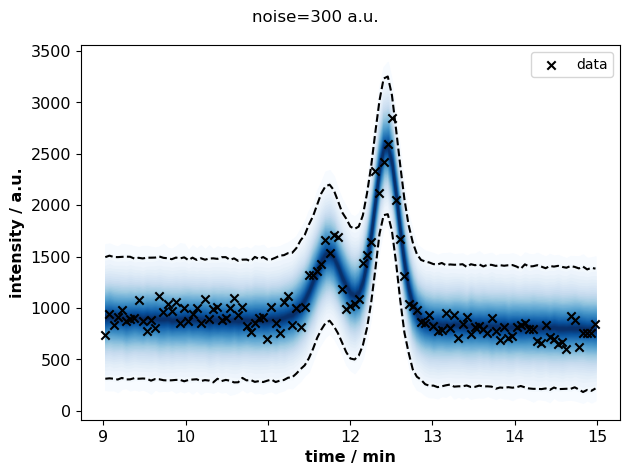

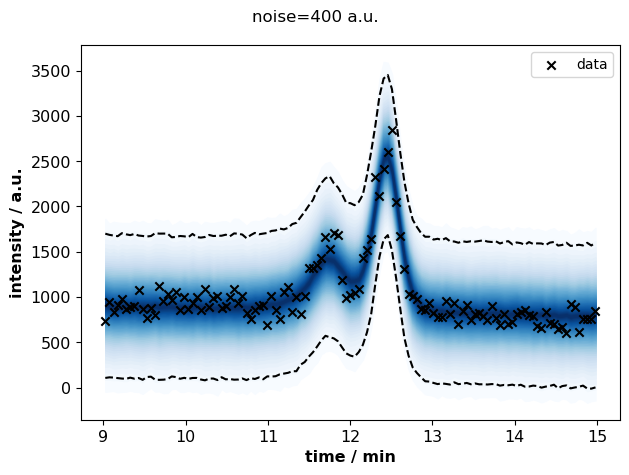

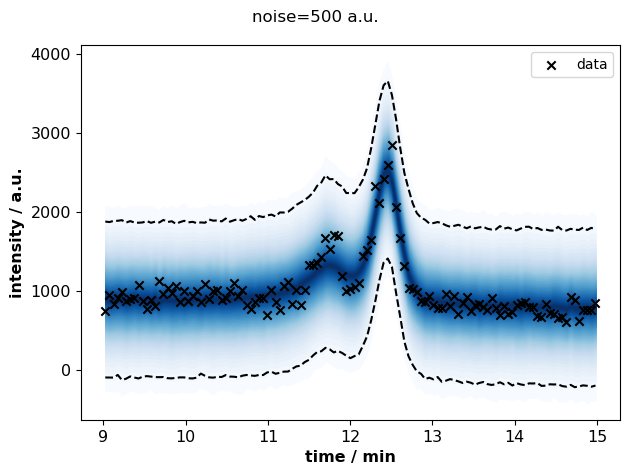

In [6]:
for s, idata in sigma_idatas.items():
    plots.plot_posterior_predictive(
        identifier="peak_fit",
        time=idata.constant_data.time.values,
        intensity=idata.constant_data.intensity.values,
        path=None,
        idata=idata,
        discarded=False,
    )
    fig = plt.gcf()
    fig.suptitle(f"noise={s} a.u.")
    fig.tight_layout()
    plt.show()

In [7]:
summary = pd.concat([
    az.summary(idata, var_names=["area"])
    for s, idata in sigma_idatas.items()
], keys=sigma_idatas, names=["noise", "var_name"])
summary

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
noise var_name                                                            
50    area[0]   313.351   11.665  291.073   334.905      0.109    0.077   
      area[1]   678.536   11.291  656.315   698.359      0.105    0.075   
100   area[0]   316.106   23.420  272.294   359.828      0.215    0.153   
      area[1]   675.603   22.394  636.958   722.187      0.200    0.142   
150   area[0]   319.884   37.831  249.006   391.667      0.369    0.263   
      area[1]   673.569   32.766  611.630   734.258      0.301    0.213   
200   area[0]   324.587   52.400  229.037   423.322      0.585    0.433   
      area[1]   670.918   44.970  592.101   761.562      0.463    0.327   
300   area[0]   358.377  125.401  160.648   551.351      2.581    2.006   
      area[1]   650.773   81.505  493.518   801.641      1.647    1.165   
400   area[0]   435.775  233.185  123.857   853.499      4.999    3.535   
      area[1]   614.937  117.477  386.018   833.273      2.432    1.720   
500   area[0]   540.067  369.859   14.128  1160.742      8.399    6.922   
      area[1]   589.281  142.407  329.538   856.490      2.730    1.931   

                ess_bulk  ess_tail  r_hat  
noise var_name                             
50    area[0]    11348.0    6043.0    1.0  
      area[1]    11806.0    5822.0    1.0  
100   area[0]    11865.0    6763.0    1.0  
      area[1]    12404.0    5899.0    1.0  
150   area[0]    10519.0    6268.0    1.0  
      area[1]    11899.0    6263.0    1.0  
200   area[0]     8537.0    5144.0    1.0  
      area[1]     9483.0    5651.0    1.0  
300   area[0]     3855.0    2160.0    1.0  
      area[1]     2905.0    1754.0    1.0  
400   area[0]     2735.0    3092.0    1.0  
      area[1]     2418.0    2722.0    1.0  
500   area[0]     2429.0    2371.0    1.0  
      area[1]     2686.0    3486.0    1.0

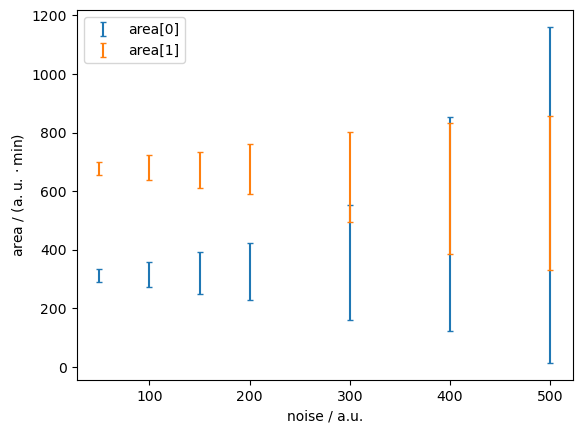

In [8]:
fig, ax = plt.subplots()

for vname, df in summary.reset_index().groupby("var_name"):
    ax.errorbar(
        df["noise"],
        y=df["mean"],
        yerr=[
            df["mean"] - df["hdi_3%"],
            df["hdi_97%"] - df["mean"],
        ],
        label=vname,
        ls="none",
        capsize=2,
    )
ax.legend()
ax.set(
    xlabel="noise / a.u.",
    ylabel="$\mathrm{area\ /\ (a.u. \cdot min)}$"
)
plt.show()

# Conclusion

* At high noise (>200 a.u.), the uncertainty about peak areas increases.
* In this case, the model fits a noise of ~115 a.u. so that's well below the critical level.

In [10]:
%load_ext watermark
%watermark -idu

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-05-11T14:43:08.623240+02:00

